# CS440/ECE448 Spring 2024
# MP08: Repeated Games

The first thing you need to do is to download this file: <a href="mp08.zip">mp08.zip</a>.  It has the following content:

* `submitted.py`: Your homework. Edit, and then submit to <a href="https://www.gradescope.com/courses/486387">Gradescope</a>.
* `mp08_notebook.ipynb`: This is a <a href="https://anaconda.org/anaconda/jupyter">Jupyter</a> notebook to help you debug.  You can completely ignore it if you want, although you might find that it gives you useful instructions.
* `grade.py`: Once your homework seems to be working, you can test it by typing `python grade.py`, which will run the tests in `tests/tests_visible.py`.
* `tests/test_visible.py`: This file contains about half of the <a href="https://docs.python.org/3/library/unittest.html">unit tests</a> that Gradescope will run in order to grade your homework.  If you can get a perfect score on these tests, then you should also get a perfect score on the additional hidden tests that Gradescope uses.
* `solution.json`: This file contains the solutions for the visible test cases, in <a href="https://docs.python.org/3/library/json.html">JSON</a> format.  If the instructions are confusing you, please look at this file, to see if it can help to clear up your confusion.
* `requirements.txt`: This tells you which python packages you need to have installed, in order to run `grade.py`.  You can install all of those packages by typing `pip install -r requirements.txt` or `pip3 install -r requirements.txt`.

This file (`mp08_notebook.ipynb`) will walk you through the whole MP, giving you instructions and debugging tips as you go.

### Table of Contents

1. <a href="#section1">Episodic Games: Gradient Ascent</a>
1. <a href="#section2">Episodic Games: Corrected Ascent</a>
1. <a href="#section3">Extra Credit: Sequential Games</a>
1. <a href="#grade">Grade Your Homework</a>

<a name="section1">

## Episodic Games: Gradient Ascent

It is possible to learn an optimal strategy for a two-player game using machine learning methods.  A simple gradient descent, however, doesn't work very well: gradient descent simultaneously on two different criteria can converge to an orbit, rather than converging to a stable point.  The first part of the MP explores this outcome.

In [1]:
import submitted, importlib
import numpy as np
import matplotlib.pyplot as plt

importlib.reload(submitted)

help(submitted.episodic_game_gradient_ascent)

Help on function episodic_game_gradient_ascent in module submitted:

episodic_game_gradient_ascent(init, rewards, nsteps, learningrate)
    nsteps of a 2-player, 2-action episodic game, strategies adapted using gradient ascent.
    
    @param:
    init (2) - intial logits for the two players
    rewards (2,2,2) - player i receives rewards[i,a,b] if player 0 plays a and player 1 plays b
    nsteps (scalar) - number of steps of gradient descent to perform
    learningrate (scalar) - learning rate
    
    @return:
    logits (nsteps,2) - logits of two players in each iteration of gradient descent
    utilities (nsteps,2) - utilities[t,i] is utility to player i of logits[t,:]
    
    Initialize: logits[0,:] = init. 
    
    Iterate: In iteration t, player 0's actions have probabilities sig2(logits[t,0]),
    and player 1's actions have probabilities sig2(logits[t,1]).
    
    The utility (expected reward) for player i is sig2(logits[t,0])@rewards[i,:,:]@sig2(logits[t,1]),
    and the 

As you can see, the intended behavior of this function is to perform `nsteps` steps of gradient descent on a simple 2-player, 2-action game.  Let's explore this.

First, this function seems to depend on the function `utility_partials`.  Let's look at that.

In [2]:
importlib.reload(submitted)

help(submitted.utility_partials)

Help on function utility_partials in module submitted:

utility_partials(R, x)
    Calculate vector of partial derivatives of utilities with respect to logits. 
    If u[i] = sig2(x[0])@R[i,:,:]@sig2(x[1]),
    then partial[i] is the derivative of u[i] with respect to x[i].
    
    @param:
    R (2,2,2) - R[i,a,b] is reward to player i if player 0 plays a, player 1 plays b
    x (2) - player i plays move j with probability softmax([0,x[i]])[j]
    
    @return:
    partial (2) - partial[i] is the derivative of u[i] with respect to x[i].
    
    HINT: You may find the functions sig2 and dsig2 to be useful.



Following up on the hint:

In [3]:
importlib.reload(submitted)

help(submitted.sig2)
help(submitted.dsig2)

Help on function sig2 in module submitted:

sig2(x)
    Calculate the vector p = [1-sigmoid(x), sigmoid(x)] for scalar x

Help on function dsig2 in module submitted:

dsig2(p)
    Assume p=sig2(x).  Calculate the vector v such that v[i] is the derivative of p[i] with respect to x.



Let's start with a rather difficult game to optimize, in which player 0 wins more if their move is the opposite of player 1's move, whereas player 1 wins more if their move is the same as that of player 0:

In [4]:
rewards = np.array([[[1,2],[2,1]],[[2,1],[1,2]]])
print(rewards)


[[[1 2]
  [2 1]]

 [[2 1]
  [1 2]]]


Once you have written the function `utility_partials`, you can experiment with the partial derivatives of the utility with respect to the players' logits:

In [5]:
importlib.reload(submitted)

print('The partial derivatives at x=[0,0] are',submitted.utility_partials(rewards,[0,0]))
print('The partial derivatives at x=[-1,0] are',submitted.utility_partials(rewards,[-1,0]))
print('The partial derivatives at x=[0,-1] are',submitted.utility_partials(rewards,[0,-1]))
print('The partial derivatives at x=[1,0] are',submitted.utility_partials(rewards,[1,0]))
print('The partial derivatives at x=[0,1] are',submitted.utility_partials(rewards,[0,1]))


The partial derivatives at x=[0,0] are [0. 0.]
The partial derivatives at x=[-1,0] are [ 0.         -0.11552929]
The partial derivatives at x=[0,-1] are [0.11552929 0.        ]
The partial derivatives at x=[1,0] are [0.         0.11552929]
The partial derivatives at x=[0,1] are [-0.11552929  0.        ]


The interpretations of these partial derivatives are something like this:

* The zero logit vector (i.e., p=sigmoid(0)=0.5 probability of cooperating, for both players) has an all-zeros vector of partial derivatives.  This means it is a Nash equilibrium: neither player wants to change strategy unless the other player changes.  With this strategy, both players have a utility (expected reward) of [0.5,0.5]@rewards[i,:,:]@[0.5,0.5] = 1.5.

* If the logits are [-1,0] (so player 0 cooperates with probability of 1/(1+exp(1)), which is greater than 0.5), then player 1 has a motivation to cooperate **less** often (du[1]/dx[1] < 0).
* If the logits are [0,-1] (so player 1 cooperates with probability of 1/(1+exp(1)), which is greater than 0.5), then player 0 has a motivation to cooperate **more** often (du[0]/dx[0] > 0).
* ... and so on.

By the way, this notebook will sometimes refer to move 1 as "cooperating," and move 0 as "defecting."  Those terms only have meaning for games like Prisoner's dilemma or Chicken, in which your opponent wins more points if you cooperate, and fewer points if you defect.  For more symmetric games, like this one, those terms don't really have any meaning, but they sound kind of nice anyway, so sometimes we will use those words.

This game has just one Nash equilibrium: if both players cooperate with probability 50%, then they both win, on average, 0.5 points per game.

This Nash equilibrium is stable: if gradient descent starts at this equilibrium, then it will stay there.

Text(0, 0.5, 'Probability that player 1 cooperates')

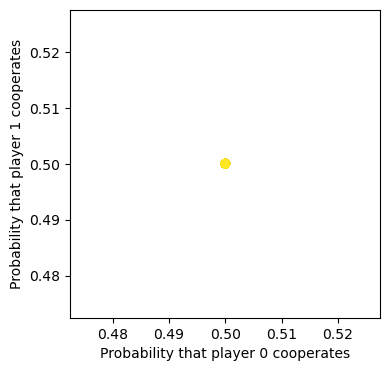

In [6]:
importlib.reload(submitted)

init = [0,0]  # Initial logits [0,0] means that initial probabilities are [0.5, 0.5]
nsteps, learningrate = 1000, 0.1
logits, utilities = submitted.episodic_game_gradient_ascent([0,0], rewards, nsteps, learningrate)

fig, ax = plt.subplots(1, figsize=(4,4))
ax.scatter(1/(1+np.exp(-logits[:,0])), 1/(1+np.exp(-logits[:,1])), c=np.arange(nsteps))
ax.set_xlabel('Probability that player 0 cooperates')
ax.set_ylabel('Probability that player 1 cooperates')

However, if we start from any position other than the equilibrium, then gradient descent fails to converge.

Text(0, 0.5, 'Probability that player 1 cooperates')

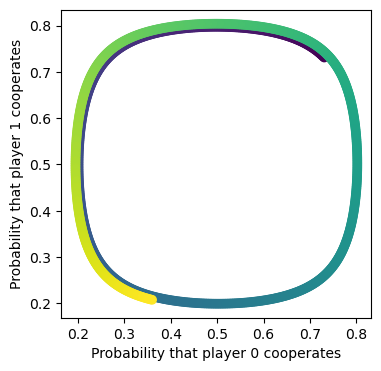

In [7]:
importlib.reload(submitted)

init = [-1,-1]  # Initial logits [-1,-1] means that initial probabilities are [1/(1+e), 1/(1+e)]
nsteps, learningrate = 1000, 0.1
logits, utilities = submitted.episodic_game_gradient_ascent([1,1], rewards, nsteps, learningrate)

fig, ax = plt.subplots(1, figsize=(4,4))
ax.scatter(1/(1+np.exp(-logits[:,0])),1/(1+np.exp(-logits[:,1])), c=np.arange(nsteps))
ax.set_xlabel('Probability that player 0 cooperates')
ax.set_ylabel('Probability that player 1 cooperates')

As you can see, gradient descent does not converge to the Nash equilibrium; instead, the players orbit around the Nash equilibrium:

* When player 1 is usually defecting, then player 0 increases their cooperation probability
* When player 0 is usually cooperating, then player 1 increases their cooperation probability
* When player 1 is usually cooperating, then player 0 decreases their cooperation probability
* When player 0 is usually defecting, then player 1 decreases their cooperation probability

<a id='section2'></a>

## Episodic Games: Corrected Ascent

The paper "The mechanics of n-player games" proposed a solution to the problem shown above, by borrowing an idea from orbital mechanics.  They suggested that we should impose some friction, so the orbit will decay toward a stable equilibrium.  They called this friction term the symplectic correction:

In [8]:
importlib.reload(submitted)

help(submitted.symplectic_correction)

Help on function symplectic_correction in module submitted:

symplectic_correction(partials, hessian)
    Calculate the symplectic correction matrix from Balduzzi et al., "The Mechanics of n-player Games," 2018.



Apparently we need to calculate the Hessian:

In [9]:
importlib.reload(submitted)

help(submitted.utility_hessian)

Help on function utility_hessian in module submitted:

utility_hessian(R, x)
    Calculate matrix of partial second derivatives of utilities with respect to logits. 
    Define u[i] = sig2(x[0])@R[i,:,:]@sig2(x[1]),
    then hessian[i,j] is the second derivative of u[j] with respect to x[i] and x[j].
    
    @param:
    R (2,2,2) - R[i,a,b] is reward to player i if player 0 plays a, player 1 plays b
    x (2) - player i plays move j with probability softmax([0,x[i]])[j]
    
    @return:
    hessian (2) - hessian[i,j] is the second derivative of u[i] with respect to x[i] and x[j].
    
    HINT: You may find the functions sig2, dsig2, and Hsig2 to be useful.



In [10]:
importlib.reload(submitted)

help(submitted.Hsig2)

Help on function Hsig2 in module submitted:

Hsig2(p)
    Assume p=sig2(x).  Calculate the vector v such that v[i] is the second derivative of p[i] with respect to x.



Once you have written the function `utility_hessian`, you can test it.  

Notice that, if `sig2(logits[t,0])` and `sig2(logits[t,1])` is any mixed equilibrium, then:

* The main diagonals of the Hessian will both be zero.  Each player cannot change their own utility by changing the probabilities with which they choose actions.
* The off-diagonal elements of the Hessian might not be zero.  In this case, player 0 would prefer that player 1 change their strategy (because then the two players would sometimes make different moves, which would benefit player 0), whereas player 1 would prefer that player 0 NOT change their strategy (because then the two players would sometimes make different moves, which harms player 1).



In [11]:
importlib.reload(submitted)

H = submitted.utility_hessian(rewards, [0,0])
print(H)

[[ 0.    -0.125]
 [ 0.125  0.   ]]


The symmetric part of the Hessian is $\mathbf{S}=0.5(\mathbf{H}+\mathbf{H}^T)$.  Notice that, because of symmetry, $\mathbf{d}^T\mathbf{H}\mathbf{d}=\mathbf{d}^T\mathbf{S}\mathbf{d}$ for any vector $\mathbf{d}$.  The symmetric part therefore has a unique relationship to stability of the Nash equilibrium:

* **Positive definite symmetric part:** changing the Nash equilibrium by any small vector, $\mathbf{d}$, causes the sum of the utilities for all players to increase, i.e., $\mathbf{d}^T\mathbf{H}\mathbf{d}>0$.  All of the eigenvalues of a positive-definite symmetric matrix are positive real numbers.  Notice that, if the Hessian's symmetric part is positive definite, the Nash equilibrium is **unstable:** no player has an incentive to change from the Nash equilibrium, but as soon as one player changes, even slightly, then all of the other players can increase their utility by making the change bigger.
* **Negative definite symmetric part:** changing the Nash equilibrium by any small vector, $\mathbf{d}$, causes the sum of the utilities for all players to decrease, i.e., $\mathbf{d}^T\mathbf{H}\mathbf{d}< 0$.  All of the eigenvalues of a negative-definite symmetric matrix are negative.  Notice that a negative definite Hessian means that the Nash equilibrium is **stable:** If any player moves away from the equilibrium by even a small amount, the utilities of the players go down or stay the same, so all players want to move back toward the equilibrium.
* **Zero-valued symmetric part:** In the example we've been working with so far, the Hessian is anti-symmetric, so its symmetric part is identically zero.  In this case, changing the Nash equilibrium by a small amount does not change the average loss at all ($\mathbf{d}^T\mathbf{H}\mathbf{d}= 0$, so, although the players have no particular incentive to move back to the equilibrium, on average they don't mind moving back to the equilibrium, so we can say that the game is **marginally stable.**
* Neither negative nor positive definite: Some eigenvalues have positive real parts, some have negative.  If one player moves away from the equilibrium in a direction $\mathbf{d}$, the other players might want to move further away ($\mathbf{d}^T\mathbf{H}\mathbf{d}$ might be positive) or they might want to move back to the equilibrium ($\mathbf{d}^T\mathbf{H}\mathbf{d}$ might be negative).

Notice that the game we've been using so far has a perfectly anti-symmetric Hessian, so its symmetric part is exactly zero:

In [14]:
S = 0.5*(H+H.T)
print(S)
print('The eigenvalues are',np.linalg.eig(S)[0])

[[0. 0.]
 [0. 0.]]
The eigenvalues are [0. 0.]


So this game is marginally stable.

In the prisoner's dilemma, in the Nash equilibrium, both players always defect. Each player would prefer that the other player cooperate, but that preference is wiped out because sigmoid(x)=0 corresponds to x=-np.inf, which is so small that any measurable change in the other player's logit has no effect, hence the entire Hessian is zero.

In [15]:
importlib.reload(submitted)
submitted.utility_hessian(np.array([[[-5,0],[-10,-1]],[[-5,-10],[0,-1]]]), [-np.inf,-np.inf])


array([[0., 0.],
       [0., 0.]])

We can test for stability by trying a logits vector that's not so extreme:

In [17]:
importlib.reload(submitted)
H = submitted.utility_hessian(np.array([[[-5,0],[-10,-1]],[[-5,-10],[0,-1]]]), [-1,-1])
print(H)
print('Its symmetric part is:')
print(0.5*(H+H.T))
print('and has eigenvalues of:',np.linalg.eig(0.5*(H+H.T))[0])


[[-0.35654709  0.15462501]
 [ 0.15462501 -0.35654709]]
Its symmetric part is:
[[-0.35654709  0.15462501]
 [ 0.15462501 -0.35654709]]
and has eigenvalues of: [-0.20192208 -0.5111721 ]


So we see that Prisoner's dilemma is a stable game.  Both players will adjust their plays, over time, in the direction of the Nash equilibrium.  

The game of chicken has a Nash equilibrium at p=0.9 (x=np.log(9)).  This Nash equilibrium is neither stable nor unstable:

In [18]:
importlib.reload(submitted)
H = submitted.utility_hessian(np.array([[[-10,2],[-1,1]],[[-10,-1],[2,1]]]), np.ones(2)*np.log(9))
print(H)
print('Its symmetric part is:')
print(0.5*(H+H.T))
print('and has eigenvalues of',np.linalg.eig(0.5*(H+H.T))[0])

[[-6.9388939e-17 -8.1000000e-02]
 [-8.1000000e-02 -6.9388939e-17]]
Its symmetric part is:
[[-6.9388939e-17 -8.1000000e-02]
 [-8.1000000e-02 -6.9388939e-17]]
and has eigenvalues of [ 0.081 -0.081]


Since the game of Chicken is neither stable nor unstable, when one player moves away from equilibrium, the other player might want to move back.  If you think about it, you can see that the player who decides to defect (e.g., by crashing their car) prefers to move away from the mixed equilibrium toward a pure equilibrium, but the other player is unhappy with this choice, because they are thereby forced to cooperate (by chickening out).  The outcome cannot be defined based on mathematics alone; it depends on the psychology of the players.

The symplectic correction is used in the function `episodic_games_corrected_ascent`:

The logits have converged to: [ 0.00086998 -0.00093214]


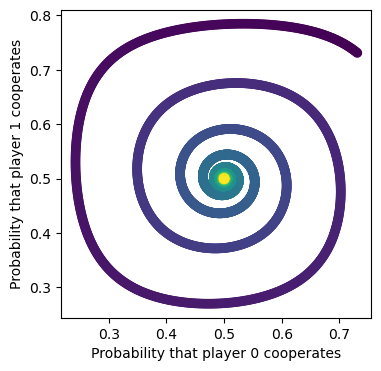

In [19]:
importlib.reload(submitted)

init = [-1,-1]  # Initial logits [-1,-1] means that initial probabilities are [1/(1+e), 1/(1+e)]
nsteps, learningrate = 5000, 0.1
logits, utilities = submitted.episodic_game_corrected_ascent([1,1], rewards, nsteps, learningrate)

fig, ax = plt.subplots(1, figsize=(4,4))
ax.scatter(1/(1+np.exp(-logits[:,0])),1/(1+np.exp(-logits[:,1])), c=np.arange(nsteps))
ax.set_xlabel('Probability that player 0 cooperates')
ax.set_ylabel('Probability that player 1 cooperates')

print('The logits have converged to:',logits[-1,:])

As you can see, the symplectic correction has added a kind of friction to the orbit, causing it to decay toward the nearest stable Nash equilibrium, with logits nearly zero, and the probability of cooperation approximately 0.5 for both players.

<a id='section3'></a>

## Extra Credit: Sequential Games

For extra credit, you can try to propose a strategy that will accumulate positive rewards, in a series of 16 sequential games of Prisoner's dilemma, against the 16 possible pure-strategy opponents.

Rather than creating a function for this, all you need to do is create a matrix to specify your strategy.  The autograder will then play your strategy against 100 random opponents.

The strategy is the variable `submitted.sequential_strategy`.
`sequential_strategy[a,b]` is the probability that your player will perform action 1
on the next round of play if, during the previous round of play, 
the other player performed action a, and your player performed action b.

Examples:
* If you want to always act uniformly at random, return [[0.5,0.5],[0.5,0.5]]
* If you want to always perform action 1, return [[1,1],[1,1]].
* If you want to return the other player's action (tit-for-tat), return [[0,0],[1,1]].
* If you want to repeat your own previous move, return [[0,1],[0,1]].
* If you want to repeat your last move with probability 0.8, and the other player's last move 
with probability 0.2, return [[0.0, 0.8],[0.2, 1.0]].

You will be scored by testing your strategy in 100 sequential games against each of the sixteen pure strategy opponents, i.e., `[[0,0],[0,0]` and `[[0,0],[0,1]` and ... and `[[1,1],[1,1]]`.  If your average score, averaged across all sixteen opponents, is above 0.2, then you pass.


In [24]:
importlib.reload(submitted)

print(submitted.sequential_strategy)

[[0.5 0.5]
 [0.5 0.5]]


As you can see, the default strategy is to cooperate with 50% probability, always, regardless of what your player or your opponent did in the last round of game play.  

The reward matrix is like Prisoner's dilemma, except that each player earns a positive score if the other player cooperates, and a negative score if the other player defects.  The rewards matrix looks like this, where the number before $\Vert$ is the reward for player A, the number after $\Vert$ is the reward for player B:

$R=\begin{array}{c|c|c|}\\&b=0&b=1\\\hline a=0& -1\Vert -1&2\Vert -2\\a=1&-2\Vert 2&1\Vert 1\end{array}$



We can see how well this strategy does against random opponents by running `grade.py`:

In [25]:
!python grade.py

You played 1600 games, against all 16 possible fixed-strategy opponents
and you won an average of 0.101875 points per game
F....
FAIL: test_extra (test_extra.TestStep)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/Users/jhasegaw/Dropbox/mark/teaching/ece448/ece448labs/spring24/mp08/src/tests/test_extra.py", line 39, in test_extra
    self.assertGreater(score/played,0.2,msg='That score is not enough to get extra credit!')
AssertionError: 0.101875 not greater than 0.2 : That score is not enough to get extra credit!

----------------------------------------------------------------------
Ran 5 tests in 0.017s

FAILED (failures=1)


In order to get the extra credit, you just need to change `submitted.sequential_strategy` to a sequential strategy that will induce your opponent to cooperate, on average, at least 20\% more often than they defect.  This is how `grade.py` will look if you succeed:

In [26]:
!python grade.py

You played 1600 games, against all 16 possible fixed-strategy opponents
and you won an average of 0.390625 points per game
Congratulations!  That score is enough for extra credit!
.....
----------------------------------------------------------------------
Ran 5 tests in 0.014s

OK


<a id='grade'></a>

## Grade your homework

If you've reached this point, and all of the above sections work, then you're ready to try grading your homework!  Before you submit it to Gradescope, try grading it on your own machine.  This will run some visible test cases (which you can read in `tests/test_visible.py`), and compare the results to the solutions (which you can read in `solution.json`).

The exclamation point (!) tells python to run the following as a shell command.  Obviously you don't need to run the code this way -- this usage is here just to remind you that you can also, if you wish, run this command in a terminal window.

The `-j` option tells `grade.py` to print out a complete JSON description, which sometimes has a little more information than the default printout.

In [27]:
!python grade.py -j

{
    "tests": [
        {
            "name": "test_extra (test_extra.TestStep)",
            "score": 10,
            "max_score": 10,
            "status": "passed",
            "output": "You played 1600 games, against all 16 possible fixed-strategy opponents\nand you won an average of 0.390625 points per game\nCongratulations!  That score is enough for extra credit!\n"
        },
        {
            "name": "test_corrected_ascent (test_hidden.TestStep)",
            "score": 25,
            "max_score": 25,
            "status": "passed"
        },
        {
            "name": "test_gradient_ascent (test_hidden.TestStep)",
            "score": 25,
            "max_score": 25,
            "status": "passed"
        },
        {
            "name": "test_corrected_ascent (test_visible.TestStep)",
            "score": 25,
            "max_score": 25,
            "status": "passed"
        },
        {
            "name": "test_gradient_ascent (test_visible.TestStep)",
            

If your `grade.py` outputs look like the above, then go ahead and:

* Submit to `MP08` on Gradescope to get credit for the main assignment
* Submit to `MP08 Extra Credit` on Gradescope to get the extra credit